In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing
from tqdm import tqdm

import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import scipy.stats as stats
import numpyro
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()


In [2]:
import mat73
data_dict = mat73.loadmat('for_vishu.mat')

2023-09-06 19:45:34,381 - root - ERROR - ERROR: MATLAB type not supported: string, (uint32)
2023-09-06 19:45:34,381 - root - ERROR - ERROR: MATLAB type not supported: string, (uint32)


In [3]:
levels = data_dict["cell_scloc_level"]
levels

['C4', 'C5', 'C6', 'C7', 'C8', 'T1']

In [4]:
from numpy import ma

mat = data_dict["MG_re_tweaked"]
mat = ma.masked_invalid(mat)

mat = mat[:, [0, 1], ...]

mat.shape

(6, 2, 22, 26)

In [5]:
def auc_ind(muscle):
    ind = AUC_MAP[muscle]
    ind = int(ind[3:])
    return ind - 1

AUC_MAP = \
        {
            "LTrapezius":'auc01', "LDeltoid":'auc02', "LBiceps":'auc03', "LTriceps":'auc04',
            "LECR":'auc05', "LFCR":'auc06', "LAPB":'auc07', "LADM":'auc08', "LTA":'auc09',
            "LEDB":'auc10', "LAH":'auc11', "RTrapezius":'auc12', "RDeltoid":'auc13', "RBiceps":'auc14',
            "RTriceps":'auc15', "RECR":'auc16', "RFCR":'auc17', "RAPB":'auc18', "RADM":'auc19',
            "RTA":'auc20', "REDB":'auc21', "RAH":'auc22'
        }

muscles = [
    "Trapezius", "Deltoid", "Biceps", "Triceps",
    "APB", "ADM"
]


In [6]:
eff = []

for i, level in enumerate(levels):
    temp_eff = []

    for muscle in muscles:
        j = auc_ind("L" + muscle)

        temp_eff.append(
            mat[i, :, j, :].mean(axis=-1).tolist()
        )

    eff.append(temp_eff)

eff = np.array(eff, dtype=float)
eff = ma.masked_invalid(eff)

In [7]:
mat.shape

(6, 2, 22, 26)

In [8]:
eff.shape

(6, 6, 2)

In [9]:
y = mat
y.shape

(6, 2, 22, 26)

In [10]:
y = y[..., [auc_ind("L" + muscle) for muscle in muscles], :]
y.shape

(6, 2, 6, 26)

In [11]:
def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))


In [12]:
t = y[2, 0, ...]
t.shape

(6, 26)

In [13]:
t.sum(axis=-1)

masked_array(data=[3.3518071256426, 0.7201882028272047,
                   20.191264949280757, 19.233550134805107,
                   15.926665342663414, 1.5002629280187492],
             mask=[False, False, False, False, False, False],
       fill_value=1e+20)

In [14]:
y_max = y.max(axis=(0, 1))[None, None, ...]
y_max.shape

(1, 1, 6, 26)

In [15]:
y = y / y_max
y.shape

(6, 2, 6, 26)

In [16]:
y_sum = y.sum(axis=-2)[..., None, :]
y_sum.shape

(6, 2, 1, 26)

In [17]:
y_ratio = y / y_sum
y_ratio.shape

(6, 2, 6, 26)

In [18]:
eff.shape       # levels x muscles x laterality

(6, 6, 2)

In [19]:
y_ratio_map = y_ratio.mean(axis=-1)
y_ratio_map.shape       # levels x laterality x muscles

(6, 2, 6)

In [20]:
most_selective = y_ratio_map[:, 0, :].argmax(axis=-1)
most_selective.shape

(6,)

In [21]:
eff.shape

(6, 6, 2)

In [22]:
most_effective = eff[:, :, 0].argmax(axis=-1)
most_effective.shape

(6,)

In [23]:
most_selective

array([0, 2, 4, 5, 0, 4])

In [24]:
most_effective

array([2, 2, 2, 3, 4, 4])

In [25]:
select_muscles = []

In [26]:
muscles

['Trapezius', 'Deltoid', 'Biceps', 'Triceps', 'APB', 'ADM']

In [27]:
most_selective

array([0, 2, 4, 5, 0, 4])

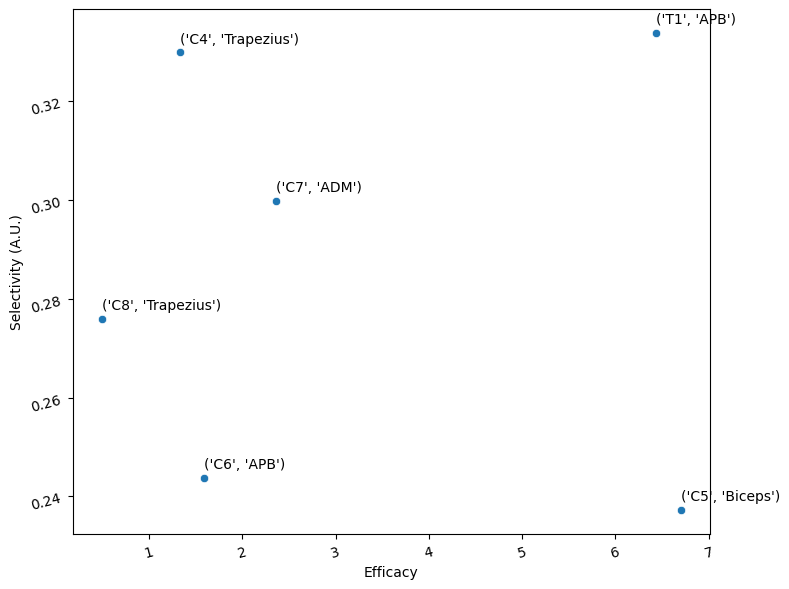

In [28]:
# axes_width = 2.5
# axis_label_size = 32
# tick_size = 22
# eeg_lw = 1
# th_alpha = 1
# fw = "normal"
# marker_len = 10
# marker_width = axes_width


nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 6), tight_layout=True, squeeze=False)
ax = axes[0, 0]


lateral_ind = 0
x_process = eff[:, :, lateral_ind]              # levels x muscles
y_process = y_ratio_map[:, lateral_ind, :]      # levels x muscles

x_val = []
y_val = []

for i, ms in enumerate(most_selective):
    x_val.append(x_process[i, ms])
    y_val.append(y_process[i, ms])

x_val = np.array(x_val)
y_val = np.array(y_val)

sns.scatterplot(x=x_val, y=y_val, ax=ax, marker="o")

for i, (xx, yy) in enumerate(zip(x_val, y_val)):
    ax.text(
        xx, yy + 0.002, (levels[i], muscles[most_selective[i]]), horizontalalignment='left'
    )

lateral_ind = 1
x_process = eff[:, :, lateral_ind]              # levels x muscles
y_process = y_ratio_map[:, lateral_ind, :]      # levels x muscles

x_val = []
y_val = []

for i, ms in enumerate(most_selective):
    x_val.append(x_process[i, ms])
    y_val.append(y_process[i, ms])

x_val = np.array(x_val)
y_val = np.array(y_val)

# sns.scatterplot(x=x_val, y=y_val, ax=ax, marker="x")

# for i, (xx, yy) in enumerate(zip(x_val, y_val)):
#     ax.text(
#         xx, yy + 0.002, (levels[i], muscles[most_selective[i]]), horizontalalignment='left'
#     )

ax.set_xlabel("Efficacy")
ax.set_ylabel("Selectivity (A.U.)")

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    # labelsize=tick_size,
    # length=marker_len,
    # width=marker_width
)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    # labelsize=tick_size,
    # length=marker_len,
    # width=marker_width
)

In [29]:
most_selective

array([0, 2, 4, 5, 0, 4])

In [30]:
muscles

['Trapezius', 'Deltoid', 'Biceps', 'Triceps', 'APB', 'ADM']

In [32]:
best = np.array([
    0, 2, 3, 5, 5, 4
])

# C4 - Trapezius
# C5 - Biceps
# C6 - Triceps
# C7 - ADM
# C8 - ADM
# T1 - APB


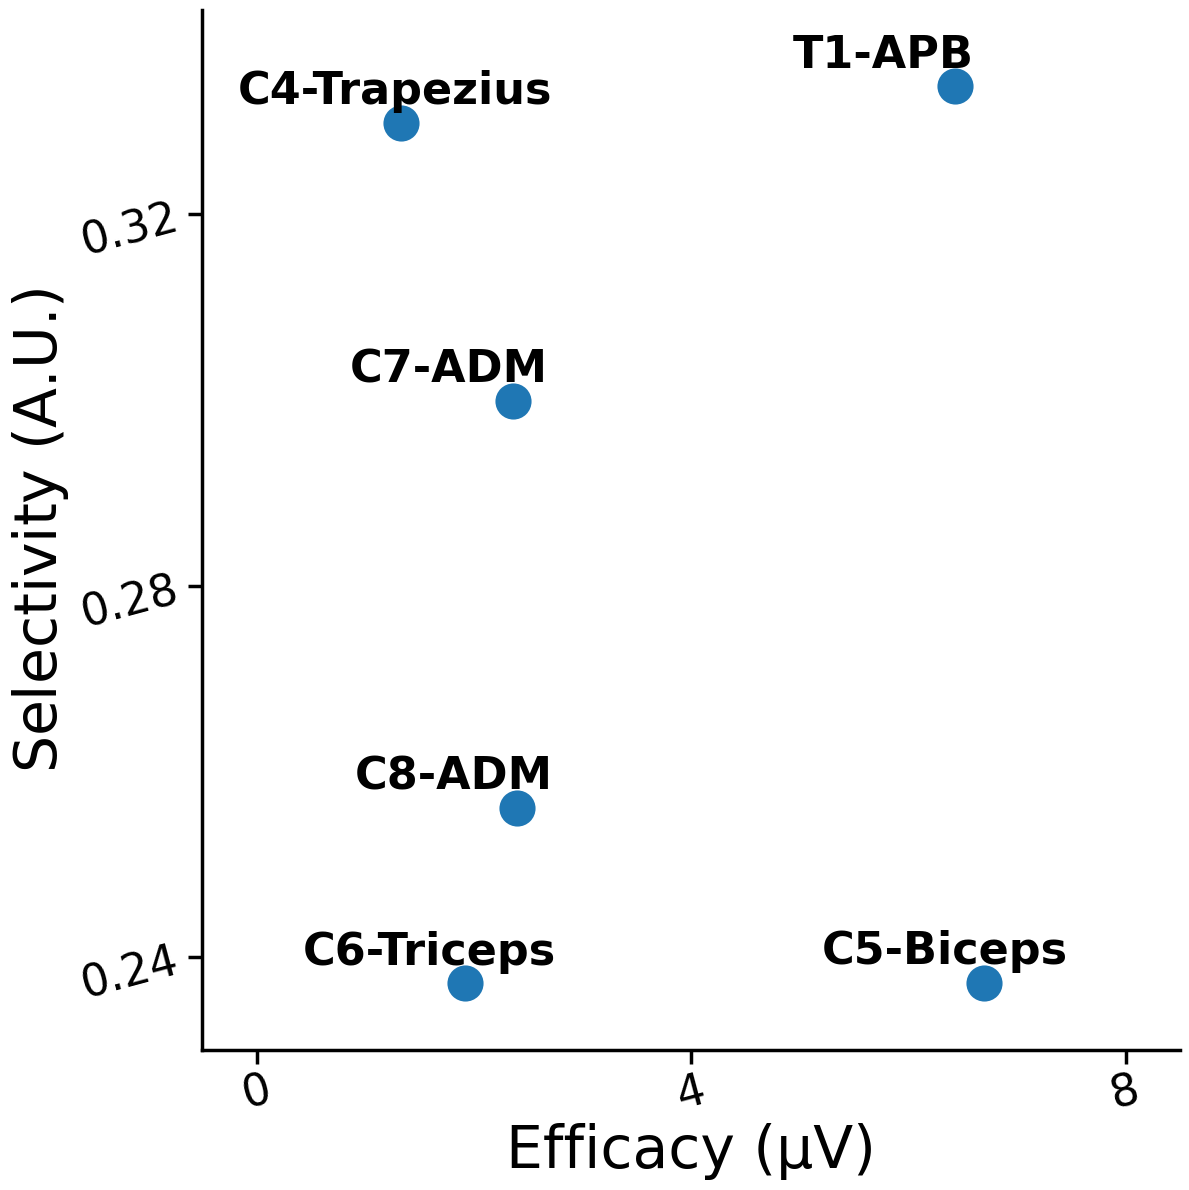

In [117]:
best = np.array([
    0, 2, 3, 5, 5, 4
])

# C4 - Trapezius
# C5 - Biceps
# C6 - Triceps
# C7 - ADM
# C8 - ADM
# T1 - APB


axes_width = 2.5
axis_label_size = 42
tick_size = 32
eeg_lw = 1
th_alpha = 1
fw = "normal"
marker_len = 10
marker_width = axes_width
infw = "bold"


nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), tight_layout=True, squeeze=False)
ax = axes[0, 0]

order_arr = best

lateral_ind = 0
x_process = eff[:, :, lateral_ind]              # levels x muscles
y_process = y_ratio_map[:, lateral_ind, :]      # levels x muscles

x_val = []
y_val = []

for i, ms in enumerate(order_arr):
    x_val.append(x_process[i, ms])
    y_val.append(y_process[i, ms])

x_val = np.array(x_val)
y_val = np.array(y_val)

sns.scatterplot(x=x_val, y=y_val, ax=ax, marker="o", s=800)

for i, (xx, yy) in enumerate(zip(x_val, y_val)):
    ax.text(
        xx - 1.5, yy + 0.002, levels[i] + "-" + muscles[order_arr[i]], horizontalalignment='left', weight=infw, size=tick_size
    )

lateral_ind = 1
x_process = eff[:, :, lateral_ind]              # levels x muscles
y_process = y_ratio_map[:, lateral_ind, :]      # levels x muscles

x_val = []
y_val = []

for i, ms in enumerate(order_arr):
    x_val.append(x_process[i, ms])
    y_val.append(y_process[i, ms])

x_val = np.array(x_val)
y_val = np.array(y_val)

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("Efficacy (μV)", size=axis_label_size, fontweight=fw)
ax.set_ylabel("Selectivity $($A.U.$)$", size=axis_label_size, fontweight=fw)

ax.set_xticks([0, 4, 8])
ax.set_xlim(left=-0.5, right=8.5)


ax.set_yticks([0.24, 0.28, 0.32])
ax.set_ylim(bottom=0.23, top=0.342)

ax.xaxis.offsetText.set_fontsize(tick_size)
ax.yaxis.offsetText.set_fontsize(tick_size)

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        for axis in ['bottom', 'left']:
            ax.spines[axis].set_linewidth(axes_width)

fig.savefig("/home/vishu/paper/figs/fig_4_background.svg", dpi=600)


In [118]:
muscles

['Trapezius', 'Deltoid', 'Biceps', 'Triceps', 'APB', 'ADM']

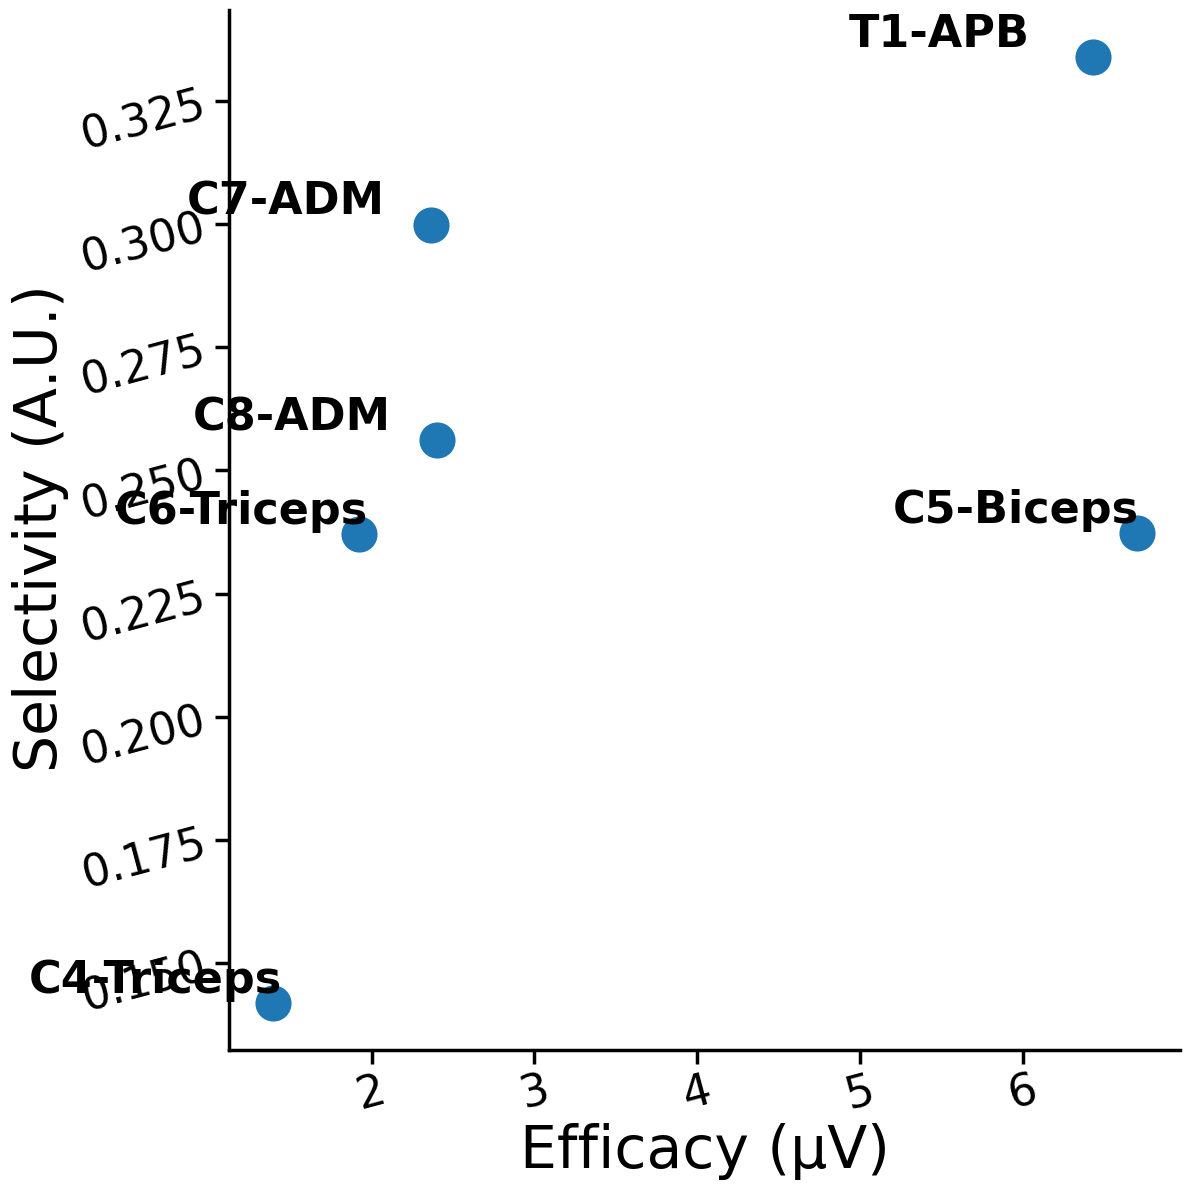

In [121]:
best = np.array([
    3, 2, 3, 5, 5, 4
])

# C4 - Trapezius
# C5 - Biceps
# C6 - Triceps
# C7 - ADM
# C8 - ADM
# T1 - APB


axes_width = 2.5
axis_label_size = 42
tick_size = 32
eeg_lw = 1
th_alpha = 1
fw = "normal"
marker_len = 10
marker_width = axes_width
infw = "bold"


nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), tight_layout=True, squeeze=False)
ax = axes[0, 0]

order_arr = best

lateral_ind = 0
x_process = eff[:, :, lateral_ind]              # levels x muscles
y_process = y_ratio_map[:, lateral_ind, :]      # levels x muscles

x_val = []
y_val = []

for i, ms in enumerate(order_arr):
    x_val.append(x_process[i, ms])
    y_val.append(y_process[i, ms])

x_val = np.array(x_val)
y_val = np.array(y_val)

sns.scatterplot(x=x_val, y=y_val, ax=ax, marker="o", s=800)

for i, (xx, yy) in enumerate(zip(x_val, y_val)):
    ax.text(
        xx - 1.5, yy + 0.002, levels[i] + "-" + muscles[order_arr[i]], horizontalalignment='left', weight=infw, size=tick_size
    )

lateral_ind = 1
x_process = eff[:, :, lateral_ind]              # levels x muscles
y_process = y_ratio_map[:, lateral_ind, :]      # levels x muscles

x_val = []
y_val = []

for i, ms in enumerate(order_arr):
    x_val.append(x_process[i, ms])
    y_val.append(y_process[i, ms])

x_val = np.array(x_val)
y_val = np.array(y_val)

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("Efficacy (μV)", size=axis_label_size, fontweight=fw)
ax.set_ylabel("Selectivity $($A.U.$)$", size=axis_label_size, fontweight=fw)

# ax.set_xticks([0, 4, 8])
# ax.set_xlim(left=-0.5, right=8.5)

# ax.set_yticks([0.24, 0.28, 0.32])
# ax.set_ylim(bottom=0.23, top=0.342)

ax.xaxis.offsetText.set_fontsize(tick_size)
ax.yaxis.offsetText.set_fontsize(tick_size)

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        for axis in ['bottom', 'left']:
            ax.spines[axis].set_linewidth(axes_width)

fig.savefig("/home/vishu/paper/figs/fig_4_background.svg", dpi=600)